# Explicit Synchronous Variational Integrators
Tim Tyree<br>
12.3.2020

In [1]:
%matplotlib inline
from lib.my_initialization import *
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


In [2]:
# #pylab
# %matplotlib inline

# import numpy as np, pandas as pd, matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D  

# from PIL import Image
# import trimesh, tetgen, pyvista as pv
# from queue import PriorityQueue

# #automate the boring stuff
# from IPython import utils
# import time, os, sys, re
# beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
# if not 'nb_dir' in globals():
#     nb_dir = os.getcwd()

# # #load the libraries
# from lib import *

# %autocall 1
# %load_ext autoreload
# %autoreload 2

In [3]:
# #enter darkmode for jupyter notebooks
# # !jt -t monokai -f fira -fs 13 -nf ptsans -nfs 11 -N -kl -cursw 5 -cursc r -cellw 95% -T

# #Hack for images to obey darkmode
# import seaborn as sns

# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# initialize_system

In [4]:
os.chdir(nb_dir)
input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
# input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
tme = 0.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=1.)
locals().update(dict_values_system)
print(list(dict_values_system.keys()))

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


# GOAL: simple tests on a solid spherical mesh of unstructured tetrahedra
12.4.2020
- DONE: implement an explicit AVI >> `explicit.py`
12.5.2020
- DONE: debugged an explicit AVI >> `explicit.py`

# define an explicit synchronous variational integrator (ESVI) and perform a trivial test

For synchronous forward euler integration of the trivial initial conditions, results appeared to be accurate to machine precision for long times when stepsize = 0.001 but not for stepsize = 0.01.  
- stepsize = 0.01 was not stable up to time tme = 10
- stepsize = 0.001 was stable & accurate up to time tme = 2 but not tme = 4


In [5]:
#define Lamé parameters
mu = 1; lam = 1;
#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
calc_P = get_calc_P(mu, lam)
compute_nodal_elastic_forces= get_compute_nodal_elastic_forces(mu, lam)

In [6]:
# def pop(time_list):
#     value = time_list[0]
#     time_list.remove(value)
#     return value

def _compute_next_time(K, t, stepsize):
    '''compute next time for element's evaluation'''
    return t + stepsize

In [7]:
# print(list(dict_values_system.keys()))

In [8]:
elements = element_array_index
vertices = node_array_position

N_elements = elements.shape[0]
N_vertices = vertices.shape[0]

momentum = node_array_momentum
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]



In [9]:
#TODO: wrap this in something like def explicit_synchronous(Q, V, M, elements, X0, t0, tf, stepsize):
t0 = tme
tf = 1.#.5#.0019
stepsize = 0.01 # 0.001 worked for tme to 2 but not 4

#push all K finite elements into the queue at initial time t0
queue = PriorityQueue()# queue = list()
#initialize all elemental times to the same time value, t0, and push all elements to queue
tauK = t0+0.*element_array_time
for K_index in list(range(N_elements)):
    tauK[K_index] = t0
    queue.put((t0, K_index))#     queue.append((t0, K_index)) 
    # tK2     = t0 # _compute_time(K, t0, stepsize, num_steps)

# initialize nodal times to initial time t0
tau = t0 + 0. * node_array_time

#iterate over the elements in time.  
#do until priority queue is empty
# while len(queue) > 0:
old_vertices = vertices.copy() 
while not queue.empty():
    #extract next element
    t, K_index = queue.get()#pop(queue)
    if t<=tf:
        #synchronous time updates
        #update node positions
        Ka = elements[K_index]
        for a in Ka:
            vertices[a] = vertices[a] + velocities[a] * (t - tau[a])
        #update node times
        for a in Ka:
            tau[a] = t

        #compute the nodal forces for each tetrahedral
        K_vertices = vertices[Ka]
        K_W = compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
        Bm  = element_array_inverse_equilibrium_position[K_index]
        f   = compute_nodal_elastic_forces(K_vertices, K_W, Bm, f = zero_mat.copy())
        
        #TODO(later): include any other forces, such as nodal forces, pressure forces, etc.
        #net nodal forces
        force = f
        
        #update node velocities 
        for j, a in enumerate(Ka):
            velocities[a] = velocities[a] + ( (t - tauK[K_index]) / node_array_mass[a]) * force[j]
        
        #TODO(later): if node is not a boundary node, set velocity to zero
        #update element's time
        tauK[K_index] = t
        #compute next time for element's evaluation
        tKnext = t + stepsize #_compute_next_time(K, t, stepsize)
        #Schedule K for next update
        queue.put((tKnext, K_index))#push( queue, (tKnext, K_index) )
        
#         #if a new time has been observed, measure the old_mesh volume. record volume and tme. update the old_mesh and time
#         if t>tme:
#             volume = compute_net_volume(old_vertices, elements)
#             volume_lst.append(volume)
#             tme_lst.append(tme)
#             #suppose synchronous time stepping
#             tme = t
#             old_vertices = vertices.copy()
            
#update momentum
for j in range(N_vertices):
    node_array_momentum[j] = node_array_mass[j] * velocities[j]
    
#update synchronous time
tme = tf
beep(1)

0

face_normals all zero, ignoring!
/usr/local/lib/python3.8/site-packages/tetgen/pytetgen.py:534: UserWarning: VTK 9 no longer accepts an offset array
  self._grid = pv.UnstructuredGrid(offset, cells, cell_type, self.node)


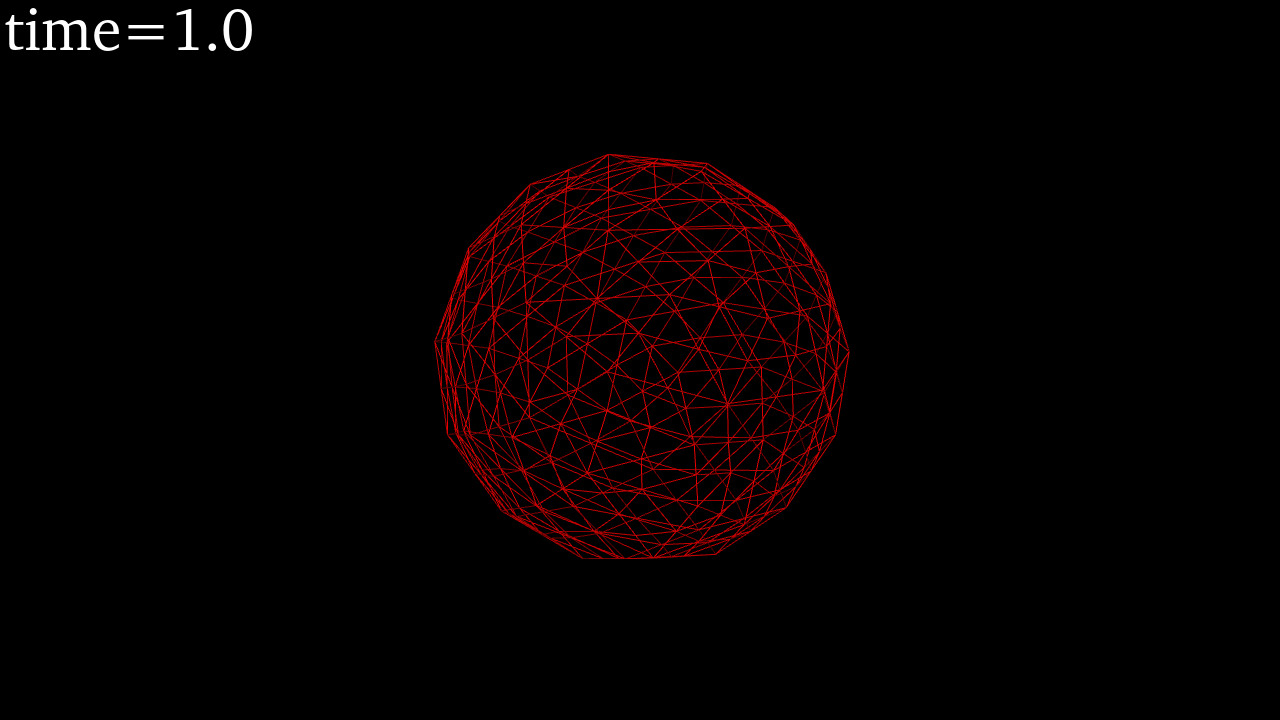

In [10]:
#visualize the mesh surface
pv.set_plot_theme('document')

#get the vtk object (wrapped by pyvista from withing tetgen.  Faces recorded by trimesh))
mesh_trimesh = trimesh.load(input_file_name)
tet = tetgen.TetGen(vertices, mesh_trimesh.faces)
tet.tetrahedralize(order=1, mindihedral=20, minratio=1.5)
tet.make_manifold()
grid = tet.grid

# advanced plotting
plotter = pv.Plotter()
plotter.set_background('k')
# plotter.add_mesh(subgrid, 'lightgrey', lighting=True)
# plotter.add_mesh(grid, 'lightgrey', lighting=True)
plotter.add_mesh(grid, 'r', 'wireframe')

text=f'time={tme:.1f}'
plotter.add_text(
    text,
    position='upper_left',
    font_size=24,
    color='w',
    font='times')
#font options
# FONT_KEYS = {'arial': vtk.VTK_ARIAL,
#              'courier': vtk.VTK_COURIER,
#              'times': vtk.VTK_TIMES}
#cpos is (camera position, focal point, and view up)
#set the camera position to some constant value
cpos = [(3.77, 3.77, 3.77),(0.0069, -0.0045, 0.0),(0.0, 0.0, 1.0)]
window_size = [1280,720] #standard aspect ratio for youtube
_cpos, img = plotter.show(title=None, return_img=True, cpos=cpos, window_size=window_size)

#Nota Bene: updating is possible
# plotter.plot(auto_close=False, interactive_update=True)
# plotter.update()
# plotter.close()

In [11]:
#TODO: if asserts still fail, check the 
# - shapes of { arrays & node features & element features }
# - forces of a few nodes
# - failing ^these, plot some forces for a known initial condition
#visualize the mesh.
#plot the mesh from a fixed camera view
#

In [12]:
#test that the updated positions and velocites effectively did not change.
print(np.max(np.abs(velocities)))
assert ( np.isclose(np.max(np.abs(velocities)),0) ) 

5.381358490869802e-15


In [13]:
#test that the updated positions and velocites effectively did not change.
print(np.max(np.abs(node_array_position - node_array_equilibrium_position)))
assert ( np.isclose(np.max(np.abs(node_array_position - node_array_equilibrium_position)),0) ) 

1.1102230246251565e-16


In [14]:
# doo = node_array_position - node_array_equilibrium_position
# boo = np.isclose(doo, 0.)
# doo[~boo]
# np.argwhere(~boo)

# perform a simple nontrivial test case for ESVI 
- visualize a simple perturbations using forward euler integration
- initialize ^that with nonzero initial velocity (perturb by stretching outward in x coord)

In [15]:
# def compute_net_volume(vertices, elements):
#     '''compute the total volume of the elements (not the interior) and the barycentric nodal volumes'''
#     N_elements = elements.shape[0]
#     net_volume = 0.
#     for K_index in range(N_elements):
#         #Behold! One tetrahedral finite volume, K
#         K_vertices = vertices[elements[K_index]]
#         #compute unsigned volume of one element
#         K_volume = compute_element_volume(vertices, elements, K_index)
#         net_volume += K_volume
#     return net_volume

In [16]:
os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
tme = 0.
mass_density=1.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
print(list(dict_values_system.keys()))

#define Lamé parameters
mu = 1; lam = 1;
#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
calc_P = get_calc_P(mu, lam)
compute_nodal_elastic_forces= get_compute_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

N_elements = elements.shape[0]
N_vertices = vertices.shape[0]

momentum = node_array_momentum.copy()

# #perturb momentum in the outward x direction and let it run overnight with a small timestep
# momentum_scale = 0.001
# momentum[:,0] = momentum_scale * vertices[:,0]
# velocities = momentum.copy()
# for j in range(N_vertices):
#     velocities[j] /= node_array_mass[j]
    
#perturb momentum in the outward x direction and let it run overnight with a small timestep
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]
v_scale = 1
velocities[:,0] = v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
tme_lst = []

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


In [17]:
# # compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
# # velocities
# # vertices
# # node_array_mass
# K_index = 7
# Ka = elements[K_index]
# K_vertices = vertices[Ka]
# # K_vertices
# K_W = compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
# Bm  = element_array_inverse_equilibrium_position[K_index]
# f   = compute_nodal_elastic_forces(K_vertices, K_W, Bm, f = zero_mat.copy())
# K_vertices

In [18]:
#TODO: wrap this in something like def explicit_synchronous(Q, V, M, elements, X0, t0, tf, stepsize):
t0 = tme
tf = 0.1#1.#0.001#.0019
stepsize = 0.001#0.0.001 # 0.001 worked for tme to 2 but not 4

#push all K finite elements into the queue at initial time t0
queue = PriorityQueue()# queue = list()
#initialize all elemental times to the same time value, t0, and push all elements to queue
tauK = t0+0.*element_array_time
for K_index in list(range(N_elements)):
    tauK[K_index] = t0
    queue.put((t0, K_index))#     queue.append((t0, K_index)) 
    # tK2     = t0 # _compute_time(K, t0, stepsize, num_steps)

# initialize nodal times to initial time t0
tau = t0 + 0. * node_array_time

#iterate over the elements in time.  
#do until priority queue is empty
# while len(queue) > 0:
old_vertices = vertices.copy() 
while not queue.empty():
    #extract next element
    t, K_index = queue.get()#pop(queue)
    if t<=tf:
        #synchronous time updates
        #update node positions
        Ka = elements[K_index]
        K_vertices = vertices[Ka]
        
        for a in Ka:
            vertices[a] = vertices[a] + velocities[a] * (t - tau[a])
        #update node times
        for a in Ka:
            tau[a] = t

        #compute the nodal forces for each tetrahedral
        K_W = compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
        Bm  = element_array_inverse_equilibrium_position[K_index]
        f   = compute_nodal_elastic_forces(K_vertices, K_W, Bm, f = zero_mat.copy())
        
        #TODO(later): include any other forces, such as nodal forces, pressure forces, etc.
        #net nodal forces
        force = f
        
        #update node velocities 
        for j, a in enumerate(Ka):
            velocities[a] = velocities[a] + ( (t - tauK[K_index]) / node_array_mass[a]) * force[j]
#             velocities[a] = velocities[a] + ( (t - tauK[K_index]) / node_array_mass[a]) * force[j]
        
        #TODO(later): if node is not a boundary node, set velocity to zero
        #update element's time
        tauK[K_index] = t
        #compute next time for element's evaluation
        tKnext = t + stepsize #_compute_next_time(K, t, stepsize)
        
        #Schedule K for next update
        queue.put((tKnext, K_index))#push( queue, (tKnext, K_index) )
        
        #if a new time has been observed, measure the old_mesh volume. record volume and tme. update the old_mesh and time
        if t>tme:
            volume = compute_net_volume(old_vertices, elements)
            volume_lst.append(volume)
            tme_lst.append(tme)
            #suppose synchronous time stepping
            tme = t
            old_vertices = vertices.copy()   
#TODO: synchronize all nodal positions with current time, tf

#update momentum
for j in range(N_vertices):
    node_array_momentum[j] = node_array_mass[j] * velocities[j]
    
#update synchronous time
tme = tf

#Bottom Line Up Front (BLUF)
beep(3)
print(tf-t0)
print(stepsize)

1.0
0.001


In [19]:
#check for nans
f


array([[ 4.89741063e-05, -1.68220435e-04, -8.81550903e-05],
       [ 6.65253135e-05,  7.63947446e-05, -1.95209915e-04],
       [-2.18439786e-04,  2.43227141e-05,  1.08021180e-04],
       [ 1.02940366e-04,  6.75029760e-05,  1.75343825e-04]])

In [20]:
#check for nans
try:
    index_of_first_nan = np.argwhere(np.isnan(np.array(volume_lst))).flatten()[0]
    time_of_first_nan = tme_lst[index_of_first_nan]
    print(time_of_first_nan)
except:
    print('nah')

nah


face_normals all zero, ignoring!


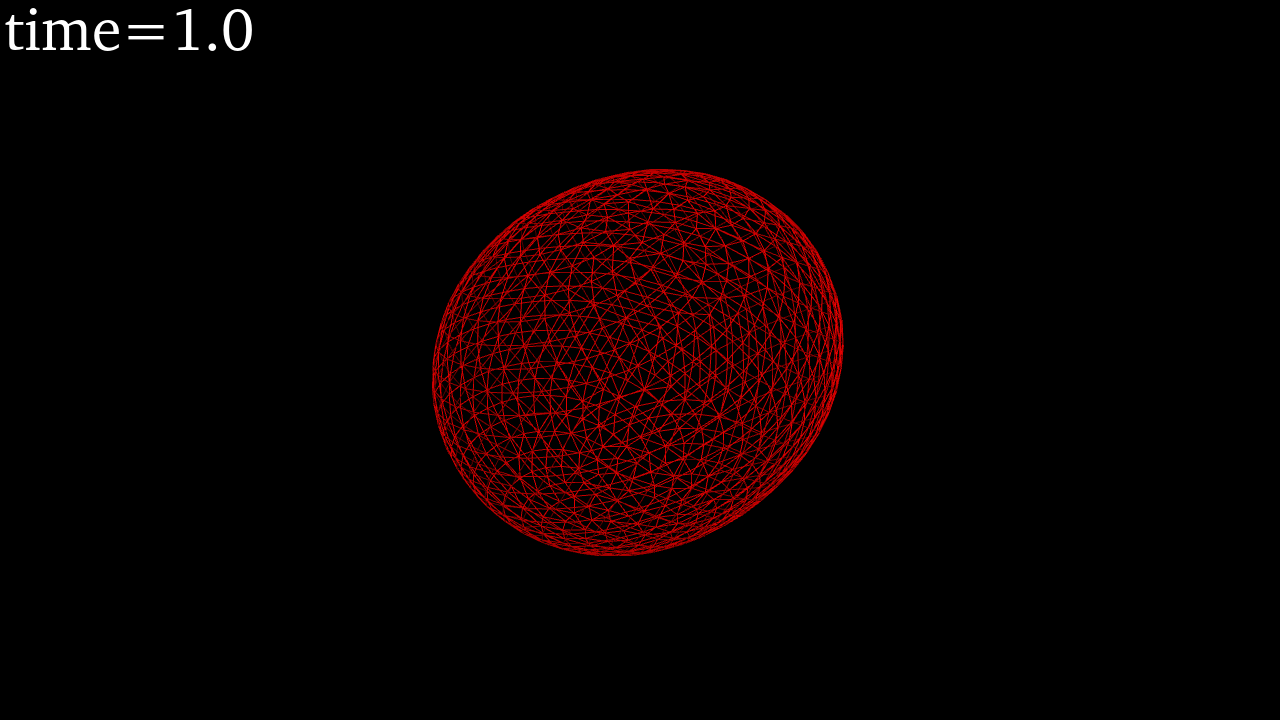

In [21]:
#visualize the mesh surface
pv.set_plot_theme('document')

#get the vtk object (wrapped by pyvista from withing tetgen.  Faces recorded by trimesh))
mesh_trimesh = trimesh.load(input_file_name)
tet = tetgen.TetGen(vertices, mesh_trimesh.faces)
tet.tetrahedralize(order=1, mindihedral=20, minratio=1.5)
tet.make_manifold()
grid = tet.grid

# advanced plotting
plotter = pv.Plotter()
plotter.set_background('k')
# plotter.add_mesh(subgrid, 'lightgrey', lighting=True)
# plotter.add_mesh(grid, 'lightgrey', lighting=True)
plotter.add_mesh(grid, 'r', 'wireframe')

text=f'time={tme:.1f}'
plotter.add_text(
    text,
    position='upper_left',
    font_size=24,
    color='w',
    font='times')
#font options
# FONT_KEYS = {'arial': vtk.VTK_ARIAL,
#              'courier': vtk.VTK_COURIER,
#              'times': vtk.VTK_TIMES}
#cpos is (camera position, focal point, and view up)
#set the camera position to some constant value
cpos = [(3.77, 3.77, 3.77),(0.0069, -0.0045, 0.0),(0.0, 0.0, 1.0)]
window_size = [1280,720] #standard aspect ratio for youtube
_cpos, img = plotter.show(title=None, return_img=True, cpos=cpos, window_size=window_size)


# (ignore) fixing broken things

## DONE: a simple priority queue

TODO(maybe?): try using 2 priority queues somehow to speed things up?  the parallel priority queue that uses bucket heaps does something like this...

In [22]:
from queue import PriorityQueue

q = PriorityQueue()

q.put((4, 'Read'))
q.put((2, 'Play'))
q.put((5, 'Write'))
q.put((1, 'Code'))
q.put((3, 'Study'))

while not q.empty():
    next_item = q.get()
    print(next_item)

(1, 'Code')
(2, 'Play')
(3, 'Study')
(4, 'Read')
(5, 'Write')


## DONE: make the simplest simulation stable

## DONE: Disect this numerical method and find the bug

In [23]:
# os.chdir(nb_dir)
# # input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
# input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
# tme = 0.
# mass_density=1.
# dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
# locals().update(dict_values_system)
# print(list(dict_values_system.keys()))

# #define Lamé parameters
# mu = 1; lam = 1;
# #get method of computing elastic forces 
# zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
# compute_nodal_elastic_forces= get_compute_nodal_elastic_forces(mu, lam)

# elements = element_array_index
# vertices = node_array_position

# N_elements = elements.shape[0]
# N_vertices = vertices.shape[0]

# momentum = node_array_momentum.copy()

# # #perturb momentum in the outward x direction and let it run overnight with a small timestep
# # momentum_scale = 0.001
# # momentum[:,0] = momentum_scale * vertices[:,0]
# # velocities = momentum.copy()
# # for j in range(N_vertices):
# #     velocities[j] /= node_array_mass[j]
    
# #perturb momentum in the outward x direction and let it run overnight with a small timestep
# velocities = momentum.copy()
# for j in range(N_vertices):
#     velocities[j] /= node_array_mass[j]
# v_scale = 1
# velocities[:,0] = v_scale * vertices[:,0].copy()

# #initialize containers of measures
# volume_lst = []
# tme_lst = []

In [24]:
# # compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
# # velocities
# # vertices
# # node_array_mass
# K_index = 7
# Ka = elements[K_index]
# K_vertices = vertices[Ka]
# # K_vertices
# K_W = compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
# Bm  = element_array_inverse_equilibrium_position[K_index]
# f   = compute_nodal_elastic_forces(K_vertices, K_W, Bm, f = zero_mat.copy())
# f

In [25]:
# #TODO: wrap this in something like def explicit_synchronous(Q, V, M, elements, X0, t0, tf, stepsize):
# t0 = tme
# tf = 1.#.5#.0019
# stepsize = 0.01 # 0.001 worked for tme to 2 but not 4

# #push all K finite elements into the queue at initial time t0
# queue = PriorityQueue()# queue = list()
# #initialize all elemental times to the same time value, t0, and push all elements to queue
# tauK = t0+0.*element_array_time
# for K_index in list(range(N_elements)):
#     tauK[K_index] = t0
#     queue.put((t0, K_index))#     queue.append((t0, K_index)) 
#     # tK2     = t0 # _compute_time(K, t0, stepsize, num_steps)

# # initialize nodal times to initial time t0
# tau = t0 + 0. * node_array_time

# #iterate over the elements in time.  
# #do until priority queue is empty
# # while len(queue) > 0:
# old_vertices = vertices.copy() 
# while not queue.empty():
#     #extract next element
#     t, K_index = queue.get()#pop(queue)
#     if t<=tf:
#         #synchronous time updates
#         #update node positions
#         Ka = elements[K_index]
#         for a in Ka:
#             vertices[a] = vertices[a] + velocities[a] * (t - tau[a])
#         #update node times
#         for a in Ka:
#             tau[a] = t

#         #compute the nodal forces for each tetrahedral
#         K_vertices = vertices[Ka]
#         K_W = compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
#         Bm  = element_array_inverse_equilibrium_position[K_index]
#         f   = compute_nodal_elastic_forces(K_vertices, K_W, Bm, f = zero_mat.copy())
        
#         #TODO(later): include any other forces, such as nodal forces, pressure forces, etc.
#         #net nodal forces
#         force = f
        
#         #update node velocities 
#         for j, a in enumerate(Ka):
#             velocities[a] = velocities[a] + ( (t - tauK[K_index]) / node_array_mass[a]) * force[j]
        
#         #TODO(later): if node is not a boundary node, set velocity to zero
#         #update element's time
#         tauK[K_index] = t
#         #compute next time for element's evaluation
#         tKnext = t + stepsize #_compute_next_time(K, t, stepsize)
#         #Schedule K for next update
#         queue.put((tKnext, K_index))#push( queue, (tKnext, K_index) )
        
#         #if a new time has been observed, measure the old_mesh volume. record volume and tme. update the old_mesh and time
#         if t>tme:
#             volume = compute_net_volume(old_vertices, elements)
#             volume_lst.append(volume)
#             tme_lst.append(tme)
#             #suppose synchronous time stepping
#             tme = t
#             old_vertices = vertices.copy()
            
# #update momentum
# for j in range(N_vertices):
#     node_array_momentum[j] = node_array_mass[j] * velocities[j]
    
# #update synchronous time
# tme = tf
# beep(3)

In [26]:
# # compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
# # velocities
# # vertices
# # node_array_mass
# K_index = 7
# Ka = elements[K_index]
# K_vertices = vertices[Ka]
# # K_vertices
# K_W = compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
# Bm  = element_array_inverse_equilibrium_position[K_index]
# f   = compute_nodal_elastic_forces(K_vertices, K_W, Bm, f = zero_mat.copy())
# f

In [27]:
# #visualize the mesh surface
# pv.set_plot_theme('document')

# #get the vtk object (wrapped by pyvista from withing tetgen.  Faces recorded by trimesh))
# mesh_trimesh = trimesh.load(input_file_name)
# tet = tetgen.TetGen(vertices, mesh_trimesh.faces)
# tet.tetrahedralize(order=1, mindihedral=20, minratio=1.5)
# tet.make_manifold()
# grid = tet.grid

# # advanced plotting
# plotter = pv.Plotter()
# plotter.set_background('k')
# # plotter.add_mesh(subgrid, 'lightgrey', lighting=True)
# # plotter.add_mesh(grid, 'lightgrey', lighting=True)
# plotter.add_mesh(grid, 'r', 'wireframe')

# text=f'time={tme:.1f}'
# plotter.add_text(
#     text,
#     position='upper_left',
#     font_size=24,
#     color='w',
#     font='times')
# #font options
# # FONT_KEYS = {'arial': vtk.VTK_ARIAL,
# #              'courier': vtk.VTK_COURIER,
# #              'times': vtk.VTK_TIMES}
# #cpos is (camera position, focal point, and view up)
# #set the camera position to some constant value
# cpos = [(3.77, 3.77, 3.77),(0.0069, -0.0045, 0.0),(0.0, 0.0, 1.0)]
# window_size = [1280,720] #standard aspect ratio for youtube
# _cpos, img = plotter.show(title=None, return_img=True, cpos=cpos, window_size=window_size)


# visualize volume versus time

In [31]:
x_values = tme_lst
y_values = np.array(volume_lst)/(4/3*np.pi)

save = False
savefn = f'../data/test/test_unit_sphere_ESVI_xstretch_w_vscale_{v_scale:.0f}_t_{tme:.0f}.png'
fig, axs = plt.subplots(ncols = 1, figsize = (4,4))

#plot energy versus time, t
ax = axs#[0]
# x_values = df['t']
# y_values = df['energy']
ax.plot(x_values,y_values, 'b', label='ESVI')
# ax.plot(x_values,energy0+0.*y_values, 'k',label='theoretical')
ax.set_xlabel('t')
# ax.legend()
ax.set_ylabel(r'volume / $\frac{4}{3}\pi r^3$')
if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    plt.tight_layout()
    plt.savefig(savefn)
print(savefn)

In [30]:
df = pd.DataFrame({'t':tme_lst,'volume':volume_lst})
df.to_csv(savefn.replace('.png','.csv'),index=False)

# Reassesment of my priority queue of TODO's

- DONE: run this simulation for a longer time
- DONE: cleanup this .ipynb briefly 
- DONE: visualize volume versus tme
- TODO(now): wrap this .ipynb functionality into a function, put that function into .py files, and test that function on ^these tests
- DONE: wrap the plotter into a function
- TODO(essential to shortest path to MVP!!!): dev. simplest adaptive time stepping
- TODO: make measures for adaptive time stepping
    - % of time steps repeated vs. t
    - stepsize distribution at time t vs. t

- TODO(later, after explicit): implement an implicit synchronous AVI as done in "An implicit time integration scheme" in 'sifakis-courseNotes-TheoryAndDiscretization.pdf'
- TODO(later): implement the dissapative backward euler method at the end of 'sifakis-courseNotes-TheoryAndDiscretization.pdf'

- TODO: njit a one step method (this forward euler integration?). measure the decrease in runtime.
    - adapt old routine to make folder of .png's
    - use old ffmpeg routine to make a snazzy movie

- TODO: make a folder of .png's of this test case
- TODO(later): make a method to automate a youtube worthy movie clip 

- TODO(later): adapt measures from `AVI implementation in 2D.ipynb` and record them over the simulation
- TODO(later, after implicit, for EP): put in local EP scalar fields
    - `grid = tet.grid`
    - `grid.add_field_array?`

In [2]:
os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
tme = 0.
mass_density=1.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
print(list(dict_values_system.keys()))

#define Lamé parameters
mu = 1; lam = 1;
#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
calc_P = get_calc_P(mu, lam)
compute_nodal_elastic_forces= get_compute_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

N_elements = elements.shape[0]
N_vertices = vertices.shape[0]

momentum = node_array_momentum.copy()

# #perturb momentum in the outward x direction and let it run overnight with a small timestep
# momentum_scale = 0.001
# momentum[:,0] = momentum_scale * vertices[:,0]
# velocities = momentum.copy()
# for j in range(N_vertices):
#     velocities[j] /= node_array_mass[j]
    
#perturb momentum in the outward x direction and let it run overnight with a small timestep
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]
v_scale = 1
velocities[:,0] = v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
tme_lst = []

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


# Compute total energy of mesh
- 1.5 seconds for one unaccelerated measurement. --> njit this before use.

In [39]:
# from lib import *

In [42]:
# def comp_element_array_energy(N_elements, element_array_mass, velocities, vertices,
#                               elements, element_array_inverse_equilibrium_position, mu, lam):
#     element_array_energy = np.zeros_like(element_array_mass)
#     for K_index in range(N_elements):
#         mass_of_K = element_array_mass[K_index]
#         Ka = elements[K_index]
#         K_velocities = velocities[Ka]
#         K_vertices= vertices[Ka]
#         K_W = compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
#         Bm  = element_array_inverse_equilibrium_position[K_index]
#         Ds = get_D_mat(K_vertices)
#         element_array_energy[K_index] = comp_element_energy(mass_of_K, K_velocities, K_W, Bm, Ds, mu, lam)
#     return element_array_energy
# def compute_net_energy(N_elements, element_array_mass, velocities, vertices,
#                               elements, element_array_inverse_equilibrium_position, mu, lam):
#     element_array_energy = comp_element_array_energy(N_elements, element_array_mass, velocities, vertices,
#                               elements, element_array_inverse_equilibrium_position, mu, lam)                                                
#     net_energy = np.sum(element_array_energy)
#     return net_energy

In [43]:
# net_energy = compute_net_energy(N_elements, element_array_mass, velocities, vertices,
#                               elements, element_array_inverse_equilibrium_position, mu, lam)

# Repeat the perturbed test with explicit rayleigh damping

In [3]:
os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
tme = 0.
mass_density=1.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
print(list(dict_values_system.keys()))

#define Lamé parameters
mu = 1.; lam = 1.; 
#define coefficient for Rayleigh damping
gamma = 1.;

#define adaptive time stepping absolute tolerances
atol_x = 1e-4; atol_v = 1e-4; 
btol_x = 1e-12; btol_v = 1e-12; 

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

N_elements = elements.shape[0]
N_vertices = vertices.shape[0]

momentum = node_array_momentum.copy()

# #perturb momentum in the outward x direction and let it run overnight with a small timestep
# momentum_scale = 0.001
# momentum[:,0] = momentum_scale * vertices[:,0]
# velocities = momentum.copy()
# for j in range(N_vertices):
#     velocities[j] /= node_array_mass[j]
    
#perturb momentum in the outward x direction and let it run overnight with a small timestep
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]
v_scale = 1
velocities[:,0] = v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
tme_lst = []

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


In [15]:
#TODO: wrap this in something like def explicit_synchronous(Q, V, M, elements, X0, t0, tf, stepsize):
t0 = tme
tf = 10#1.#0.001#.0019
stepsize = 0.001#0.0.001 # 0.001 worked for tme to 2 but not 4

#push all K finite elements into the queue at initial time t0
queue = PriorityQueue()# queue = list()
#initialize all elemental times to the same time value, t0, and push all elements to queue
tauK = t0+0.*element_array_time
for K_index in list(range(N_elements)):
    tauK[K_index] = t0
    queue.put((t0, K_index))#     queue.append((t0, K_index)) 
    # tK2     = t0 # _compute_time(K, t0, stepsize, num_steps)

# initialize nodal times to initial time t0
tau = t0 + 0. * node_array_time

#iterate over the elements in time.  
#do until priority queue is empty
# while len(queue) > 0:
old_vertices = vertices.copy() 
while not queue.empty():
    #extract next element
    t, K_index = queue.get()#pop(queue)
    if t<=tf:
        #synchronous time updates
        #update node positions
        Ka = elements[K_index]
        K_vertices = vertices[Ka]
        K_velocities = velocities[Ka]
        for a in Ka:
            vertices[a] = vertices[a] + velocities[a] * (t - tau[a])
        #update node times
        for a in Ka:
            tau[a] = t

        #compute the nodal forces for each tetrahedral
        K_W = compute_element_volume(node_array_position=vertices, element_array_index=elements, K_index=K_index)
        Bm  = element_array_inverse_equilibrium_position[K_index]
        Ds  = get_D_mat(K_vertices)
        fe   = comp_nodal_elastic_forces(K_W, Bm, Ds, f_out = zero_mat.copy())
        fd   = compute_nodal_damping_forces(K_velocities, Ds, K_W, Bm, delta_f=zero_mat.copy())

        #TODO(later): include any other forces, such as nodal forces, pressure forces, etc.
        #net nodal forces
        force = fe + fd
        
        #update node velocities 
        for j, a in enumerate(Ka):
            velocities[a] = velocities[a] + ( (t - tauK[K_index]) / node_array_mass[a]) * force[j]
#             velocities[a] = velocities[a] + ( (t - tauK[K_index]) / node_array_mass[a]) * force[j]
        
        #TODO(later): if node is not a boundary node, set velocity to zero
        #update element's time
        tauK[K_index] = t
        #compute next time for element's evaluation
        tKnext = t + stepsize #_compute_next_time(K, t, stepsize)
        
        #Schedule K for next update
        queue.put((tKnext, K_index))#push( queue, (tKnext, K_index) )
        
        #if a new time has been observed, measure the old_mesh volume. record volume and tme. update the old_mesh and time
        if t>tme:
            volume = compute_net_volume(old_vertices, elements)
            volume_lst.append(volume)
            tme_lst.append(tme)
            #suppose synchronous time stepping
            tme = t
            old_vertices = vertices.copy()   

            #synchronize all nodal positions with current time, tf
for K_index in range(N_elements):
    Ka = elements[K_index]
    for a in Ka:
        vertices[a] = vertices[a] + velocities[a] * (tf - tau[a])
    #update node times
    for a in Ka:
        tau[a] = tf
#update momentum
for j in range(N_vertices):
    node_array_momentum[j] = node_array_mass[j] * velocities[j]
    
#update synchronous time
tme = tf

#Bottom Line Up Front (BLUF)
beep(3)
print(tf-t0)
print(stepsize)

KeyboardInterrupt: 

In [ ]:
force

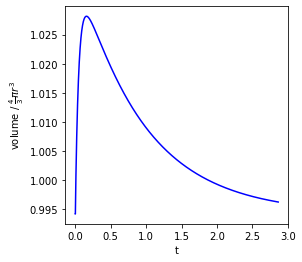

../data/test/test_unit_sphere_ESVI_xstretch_w_vscale_1_t_3.png


In [16]:
x_values = tme_lst
y_values = np.array(volume_lst)/(4/3*np.pi)

save = False
savefn = f'../data/test/test_unit_sphere_ESVI_xstretch_w_vscale_{v_scale:.0f}_t_{tme:.0f}.png'
fig, axs = plt.subplots(ncols = 1, figsize = (4,4))

#plot energy versus time, t
ax = axs#[0]
# x_values = df['t']
# y_values = df['energy']
ax.plot(x_values,y_values, 'b', label='ESVI')
# ax.plot(x_values,energy0+0.*y_values, 'k',label='theoretical')
ax.set_xlabel('t')
# ax.legend()
ax.set_ylabel(r'volume / $\frac{4}{3}\pi r^3$')
if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    plt.tight_layout()
    plt.savefig(savefn)
print(savefn)

face_normals all zero, ignoring!


nah


/usr/local/lib/python3.8/site-packages/tetgen/pytetgen.py:534: UserWarning: VTK 9 no longer accepts an offset array
  self._grid = pv.UnstructuredGrid(offset, cells, cell_type, self.node)


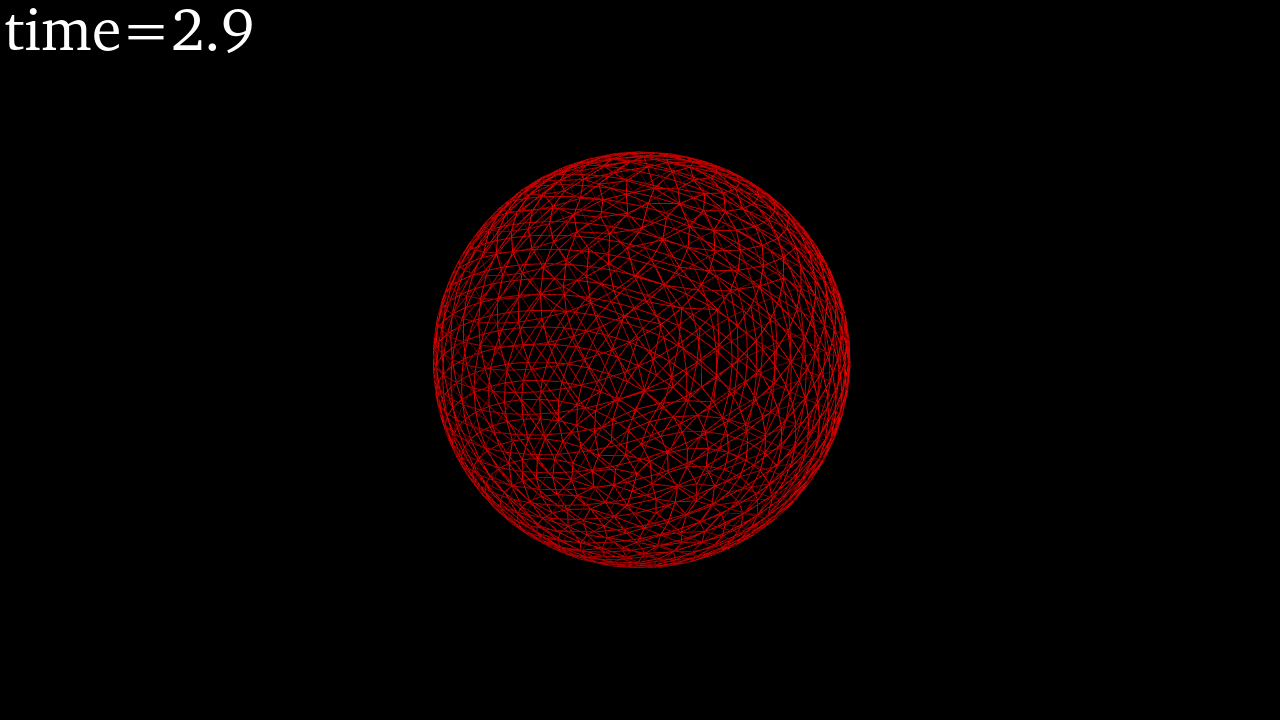

In [17]:
#check for nans
try:
    index_of_first_nan = np.argwhere(np.isnan(np.array(volume_lst))).flatten()[0]
    time_of_first_nan = tme_lst[index_of_first_nan]
    print(time_of_first_nan)
except:
    print('nah')

#visualize the mesh surface
pv.set_plot_theme('document')

#get the vtk object (wrapped by pyvista from withing tetgen.  Faces recorded by trimesh))
mesh_trimesh = trimesh.load(input_file_name)
tet = tetgen.TetGen(vertices, mesh_trimesh.faces)
tet.tetrahedralize(order=1, mindihedral=20, minratio=1.5)
tet.make_manifold()
grid = tet.grid

# advanced plotting
plotter = pv.Plotter()
plotter.set_background('k')
# plotter.add_mesh(subgrid, 'lightgrey', lighting=True)
# plotter.add_mesh(grid, 'lightgrey', lighting=True)
plotter.add_mesh(grid, 'r', 'wireframe')

text=f'time={tme:.1f}'
plotter.add_text(
    text,
    position='upper_left',
    font_size=24,
    color='w',
    font='times')
#font options
# FONT_KEYS = {'arial': vtk.VTK_ARIAL,
#              'courier': vtk.VTK_COURIER,
#              'times': vtk.VTK_TIMES}
#cpos is (camera position, focal point, and view up)
#set the camera position to some constant value
cpos = [(3.77, 3.77, 3.77),(0.0069, -0.0045, 0.0),(0.0, 0.0, 1.0)]
window_size = [1280,720] #standard aspect ratio for youtube
_cpos, img = plotter.show(title=None, return_img=True, cpos=cpos, window_size=window_size)


In [12]:
savefn = f'../data/test/test_unit_sphere_ESVI_xstretch_w_damping_w_vscale_{v_scale:.0f}_t_{tme:.0f}.png'
savefn

'../data/test/test_unit_sphere_ESVI_xstretch_w_damping_w_vscale_1_t_3.png'

In [13]:
df = pd.DataFrame({'t':tme_lst,'volume':volume_lst})
df.to_csv(savefn.replace('.png','.csv'),index=False)